<a href="https://colab.research.google.com/github/mismatchgit/UNB_MCS/blob/main/Project_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
#Except pandas, all other library we used are intalled in the VM
#Installing pandas library
!pip install pandas

In [6]:
#this is only for google colab.
!pip install gensim

In [7]:
#importing all the library required for running the code
import csv
import math
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, classification_report
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from tqdm.auto import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from gensim.models import Word2Vec
import re



   HITId                                              tweet  \
0      0  If America had another 8 years of Obama's ideo...   
1      1  Most Canadians have never met seen or associat...   
2      2                         Hahaha grow up faggot @URL   
3      3  @user queue is fucking retarded it makes every...   
4      4  @user Que ce ne soit pas des Burundais refugie...   

                                      sentiment directness  \
0  fearful_abusive_hateful_disrespectful_normal   indirect   
1                                     offensive   indirect   
2                                     offensive   indirect   
3                             offensive_hateful     direct   
4                                hateful_normal   indirect   

                annotator_sentiment              target          group  
0  anger_fear_shock_sadness_disgust              origin          other  
1              sadness_indifference          disability  special_needs  
2                     shock_d

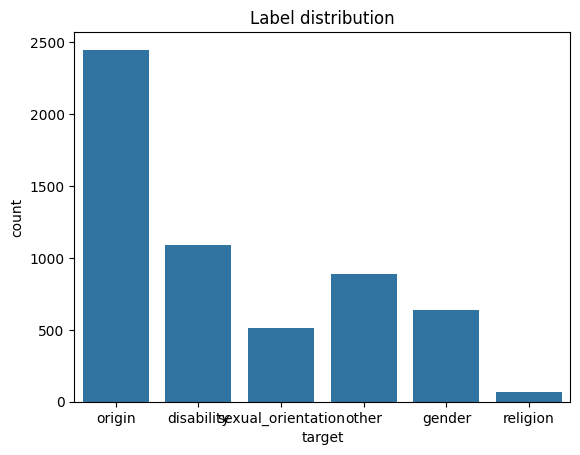


Tweet length stats:
count    5647.000000
mean       79.788206
std        39.314717
min         5.000000
25%        45.000000
50%        79.000000
75%       115.000000
max       745.000000
Name: tweet_len, dtype: float64


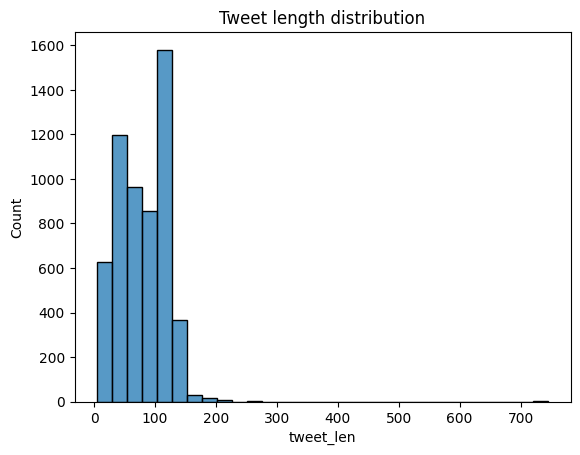

In [31]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

DATA_PATH = "/content/en_dataset_with_stop_words.csv"

# 1. Load data
df = pd.read_csv(DATA_PATH)

# 2. Basic structure
print(df.head())
print("\nInfo:")
print(df.info())
print("\nMissing values per column:")
print(df.isna().sum())

# 3. Label distribution
print("\nLabel counts:")
print(df['target'].value_counts())

sns.countplot(x='target', data=df)
plt.title("Label distribution")
plt.show()

# 4. Tweet length distribution
df['tweet_len'] = df['tweet'].astype(str).str.len()
print("\nTweet length stats:")
print(df['tweet_len'].describe())

sns.histplot(df['tweet_len'], bins=30)
plt.title("Tweet length distribution")
plt.show()


In [8]:
#Defining the data path for the dataset
DATA_PATH = "/content/en_dataset_with_stop_words.csv"

In [9]:
# This function loads data from the csv, splits the data into train,validation and test
#It also converts the target column into numerical values and renames it to label_id
#this function is used for loading data for all 4 models
def load_and_split_data(path, text_col='tweet', label_col='target',
                        test_size=0.2, val_size=0.5, random_state=42):
    df = pd.read_csv(path)
    df = df[[text_col, label_col]].dropna()

    le = LabelEncoder()
    df['label_id'] = le.fit_transform(df[label_col])

    train_df, temp_df = train_test_split(
        df, test_size=test_size, random_state=random_state,
        stratify=df['label_id']
    )
    val_df, test_df = train_test_split(
        temp_df, test_size=val_size, random_state=random_state,
        stratify=temp_df['label_id']
    )

    return train_df, val_df, test_df, le


#Instead of using the nltk library following 2 functions transforms the #sentences into tokens(inspired from assignments)
#these 2 functions are specifically for baseline model
word_tokenize_pattern = re.compile(r"(?u)\b\w\w+\b")

def word_tokenize(s):
    return [x.lower() for x in word_tokenize_pattern.findall(str(s))]

#this fucntion gets the test,train and validation data and tokenize them using the above function
def tokenize_splits(train_df, val_df, test_df, text_col='tweet'):
    X_train_tok = [word_tokenize(t) for t in train_df[text_col]]
    X_val_tok   = [word_tokenize(t) for t in val_df[text_col]]
    X_test_tok  = [word_tokenize(t) for t in test_df[text_col]]
    return X_train_tok, X_val_tok, X_test_tok

#this function handles the printing of all the results for all the models
def print_model_results(results, show_test_report=False,
                        test_labels=None, label_names=None):
    print(f"\n=== {results['name']} ===")
    print("Validation:")
    print("  Accuracy:  ", f"{results['val_acc']:.3f}")
    print("  Macro F1:  ", f"{results['val_macro_f1']:.3f}")
    print("  Micro F1:  ", f"{results['val_micro_f1']:.3f}")

    print("\nTest:")
    print("  Accuracy:  ", f"{results['test_acc']:.3f}")
    print("  Macro F1:  ", f"{results['test_macro_f1']:.3f}")
    print("  Micro F1:  ", f"{results['test_micro_f1']:.3f}")

    if show_test_report and test_labels is not None and label_names is not None:
        print("\nClassification report (test):")
        print(classification_report(test_labels,
                                    results["test_pred"],
                                    target_names=label_names))


# Following function is kind of the orchestrator of the logistic regression
# model. So it receives the data, counts the words and converts them into
# vector. Then trains the model and gets the results.
def run_countvec_logreg(train_texts, train_labels,
                        val_texts, val_labels,
                        test_texts, test_labels,
                        tokenizer_fn):
    # Using the same tokenizer as Naive Bayes so it makes a good comparison
    count_vectorizer = CountVectorizer(analyzer=tokenizer_fn)

    #transforming all(train,test and validation) data into vectors
    train_counts = count_vectorizer.fit_transform(train_texts)
    val_counts   = count_vectorizer.transform(val_texts)
    test_counts  = count_vectorizer.transform(test_texts)

    #initializing the model from Sci-kit learn library
    lr = LogisticRegression(max_iter=500, random_state=0)

    #training the model
    lr_classifier = lr.fit(train_counts, train_labels)

    # validating the model on the validation data
    val_pred = lr_classifier.predict(val_counts)
    val_acc = accuracy_score(val_labels, val_pred)
    val_macro_f1 = f1_score(val_labels, val_pred, average='macro')
    val_micro_f1 = f1_score(val_labels, val_pred, average='micro')

    # Predicting on the Test data
    test_pred = lr_classifier.predict(test_counts)
    test_acc = accuracy_score(test_labels, test_pred)
    test_macro_f1 = f1_score(test_labels, test_pred, average='macro')
    test_micro_f1 = f1_score(test_labels, test_pred, average='micro')

    return {
        "name": "CountVec + LR",
        "model": lr_classifier,
        "vectorizer": count_vectorizer,
        "val_acc": val_acc,
        "val_macro_f1": val_macro_f1,
        "val_micro_f1": val_micro_f1,
        "test_acc": test_acc,
        "test_macro_f1": test_macro_f1,
        "test_micro_f1": test_micro_f1,
        "test_pred": test_pred,
    }


In [10]:
# Loading and splitting data
train_df, val_df, test_df, le = load_and_split_data(DATA_PATH)


In [11]:

# Extracting the raw texts and numeric labels from the data
def extract_texts_and_labels(train_df, val_df, test_df,
                             text_col='tweet', label_col='label_id'):
    train_texts = train_df[text_col].tolist()
    train_labels = train_df[label_col].tolist()
    val_texts   = val_df[text_col].tolist()
    val_labels  = val_df[label_col].tolist()
    test_texts  = test_df[text_col].tolist()
    test_labels = test_df[label_col].tolist()
    return train_texts, train_labels, val_texts, val_labels, test_texts, test_labels

train_texts, train_labels, val_texts, val_labels, test_texts, test_labels = extract_texts_and_labels(train_df, val_df, test_df)

#Calling the Training method of LR and getting the metrics
countvec_lr_results = run_countvec_logreg(
    train_texts, train_labels,
    val_texts,   val_labels,
    test_texts,  test_labels,
    tokenizer_fn=word_tokenize
)

#Printing results for the logistic regression model
print_model_results(
    countvec_lr_results,
    show_test_report=True,
    test_labels=test_labels,
    label_names=le.classes_
)



=== CountVec + LR ===
Validation:
  Accuracy:   0.710
  Macro F1:   0.591
  Micro F1:   0.710

Test:
  Accuracy:   0.710
  Macro F1:   0.621
  Micro F1:   0.710

Classification report (test):
                    precision    recall  f1-score   support

        disability       0.73      0.83      0.78       109
            gender       0.62      0.64      0.63        64
            origin       0.78      0.83      0.80       245
             other       0.42      0.24      0.30        89
          religion       1.00      0.29      0.44         7
sexual_orientation       0.70      0.84      0.77        51

          accuracy                           0.71       565
         macro avg       0.71      0.61      0.62       565
      weighted avg       0.69      0.71      0.69       565



In [12]:

# Following is the code for training the multinomial naive bayes (inspired from the assignments)

class NB:
    #initializing the class with some required variables and checks
    def __init__(self, documents, labels, binary=False):
        assert len(documents) == len(labels)
        self.binary = binary
        self.counts_of_words = {}
        self.total_documents_in_each_class = {}
        self.vocab = set()
        self.train(documents, labels)

    #training the model(getting the counts)
    def train(self, documents, labels):
        for d, l in zip(documents, labels):
            self.total_documents_in_each_class[l] = self.total_documents_in_each_class.get(l, 0) + 1

            if l not in self.counts_of_words:
                self.counts_of_words[l] = {}

            tokens = word_tokenize(d)
            if self.binary:
                tokens = set(tokens)

            for t in tokens:
                self.counts_of_words[l][t] = self.counts_of_words[l].get(t, 0) + 1

        for words in self.counts_of_words.values():
            self.vocab.update(words.keys())

    #doing some sanity checks
    def sanity_check(self):
        # Checking if the priors sum to 1
        total_docs = sum(self.total_documents_in_each_class.values())
        class_priors = {c: self.total_documents_in_each_class[c] / total_docs
                        for c in self.total_documents_in_each_class}
        prior_sum = sum(class_priors.values())
        # assert abs(prior_sum - 1.0) < 1e-6, f"Class priors do not sum to 1 (sum={prior_sum})"
        # print(f"Class priors sum to 1 (sum={prior_sum})")

        # Checking if each class's word distribution sums to 1 (with Laplace
        # smoothing)
        vocab_size = len(self.vocab)
        for c in self.counts_of_words.keys():
            total_words_in_class = sum(self.counts_of_words[c].values())
            probs_sum = 0.0
            for w in self.vocab:
                word_count = self.counts_of_words[c].get(w, 0)
                p = (word_count + 1) / (total_words_in_class + vocab_size)
                probs_sum += p

            # assert abs(probs_sum - 1.0) < 1e-6, \
            #     f"Word probabilities for class '{c}' sum to {probs_sum}, not 1"
            # print(f"Word probabilities for class '{c}' sum to 1 (sum={probs_sum})")

        # print("All sanity checks passed!")

    #predicting on all the test data
    def classify(self, test_instance):
        tokens = word_tokenize(test_instance)
        if self.binary:
            tokens = set(tokens)

        prediction = {}
        total_docs = sum(self.total_documents_in_each_class.values())

        for c in self.total_documents_in_each_class.keys():
            prior = self.total_documents_in_each_class[c] / total_docs
            total_words_in_class = sum(self.counts_of_words[c].values())
            vocab_size = len(self.vocab)

            log_prob = math.log(prior)
            for t in tokens:
                word_count = self.counts_of_words[c].get(t, 0)
                prob = (word_count + 1) / (total_words_in_class + vocab_size)
                log_prob += math.log(prob)

            prediction[c] = log_prob

        return max(prediction, key=prediction.get)


# Following function is kind of the orchestrator of the Multinomial Naive Bayes
# model. So it receives the data, calls the neccessary functions. Then training
# the model and getting the results.
def run_nb_baseline(train_df, val_df, test_df, le,
                    text_col='tweet', label_col='label_id',
                    binary=False):
    (train_texts, train_labels,
     val_texts, val_labels,
     test_texts, test_labels) = extract_texts_and_labels(
        train_df, val_df, test_df, text_col, label_col
    )

    nb_classifier = NB(train_texts, train_labels, binary=binary)
    nb_classifier.sanity_check()

    val_preds = [nb_classifier.classify(x) for x in val_texts]
    val_acc = accuracy_score(val_labels, val_preds)
    val_macro_f1 = f1_score(val_labels, val_preds, average='macro')
    val_micro_f1 = f1_score(val_labels, val_preds, average='micro')

    test_preds = [nb_classifier.classify(x) for x in test_texts]
    test_acc = accuracy_score(test_labels, test_preds)
    test_macro_f1 = f1_score(test_labels, test_preds, average='macro')
    test_micro_f1 = f1_score(test_labels, test_preds, average='micro')

    return {
        "name": "Naive Bayes",
        "model": nb_classifier,
        "val_acc": val_acc,
        "val_macro_f1": val_macro_f1,
        "val_micro_f1": val_micro_f1,
        "test_acc": test_acc,
        "test_macro_f1": test_macro_f1,
        "test_micro_f1": test_micro_f1,
        "test_pred": test_preds,
    }



In [13]:
#calling the training function
nb_results = run_nb_baseline(train_df, val_df, test_df, le)

#printing the results
print_model_results(
    nb_results,
    show_test_report=True,
    test_labels=test_df['label_id'].tolist(),
    label_names=le.classes_
)



=== Naive Bayes ===
Validation:
  Accuracy:   0.614
  Macro F1:   0.428
  Micro F1:   0.614

Test:
  Accuracy:   0.625
  Macro F1:   0.448
  Micro F1:   0.625

Classification report (test):
                    precision    recall  f1-score   support

        disability       0.74      0.71      0.72       109
            gender       0.65      0.38      0.48        64
            origin       0.63      0.87      0.73       245
             other       0.33      0.20      0.25        89
          religion       0.00      0.00      0.00         7
sexual_orientation       0.71      0.39      0.51        51

          accuracy                           0.62       565
         macro avg       0.51      0.42      0.45       565
      weighted avg       0.61      0.62      0.60       565



In [22]:

# Following code prepares the dataset to be used with pytorch tensors
class HateSpeechDataset(Dataset):
    #initializing with some values
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = list(texts)
        self.labels = list(labels)
        self.tokenizer = tokenizer
        self.max_length = max_length

    #getting the length
    def __len__(self):
        return len(self.texts)

    #getting the texts, tokenizing them and transforming tha labels into tensors
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        enc = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        return {
            'input_ids': enc['input_ids'].squeeze(0),
            'attention_mask': enc['attention_mask'].squeeze(0),
            'labels': torch.tensor(label, dtype=torch.long)
        }


# initializing the model and tokenizer to be used (downloading also)
def build_model_and_tokenizer(model_name, num_labels):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=num_labels
    )
    return model, tokenizer


# preparing the dataloader  to use with this dataset
def build_dataloaders(train_df, val_df, test_df, tokenizer,
                      text_col='tweet', label_col='label_id',
                      max_length=128, train_bs=16, eval_bs=16):
    #getting the data from the HateSpeechDataset class
    train_dataset = HateSpeechDataset(train_df[text_col], train_df[label_col], tokenizer, max_length)
    val_dataset   = HateSpeechDataset(val_df[text_col],   val_df[label_col],   tokenizer, max_length)
    test_dataset  = HateSpeechDataset(test_df[text_col],  test_df[label_col],  tokenizer, max_length)

    # using the Dataloder function to prepare the data for training in batches
    # of 16
    train_loader = DataLoader(train_dataset, batch_size=train_bs, shuffle=True)
    val_loader   = DataLoader(val_dataset,   batch_size=eval_bs, shuffle=False)
    test_loader  = DataLoader(test_dataset,  batch_size=eval_bs, shuffle=False)

    return train_loader, val_loader, test_loader



#This function is used for evaluation and getting all the metrics

def evaluate(model, loader, device):
    model.eval()
    all_preds, all_labels = [], []

    #turning of the gradient tracking as we are only evaluating not training
    with torch.no_grad():
        #for every batch move the variables to gpu or cpu
        for batch in loader:
            input_ids      = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels         = batch['labels'].to(device)

            #getting outputs for every batch
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            logits = outputs.logits
            #transforming the logits into output classes
            preds = torch.argmax(logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    #getting the metrics
    acc = accuracy_score(all_labels, all_preds)
    macro_f1 = f1_score(all_labels, all_preds, average='macro')
    micro_f1 = f1_score(all_labels, all_preds, average='micro')
    return acc, macro_f1, micro_f1, all_preds



#this function handles the training part

def train_model(model, train_loader, val_loader, device,
                num_epochs=3, lr=5e-5):

    #initializing with the Adam Optimizer
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    last_val = None

    #looping through each epochs
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0

        #using tqdm to show progress bar
        loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
        #for every batch move the variables to gpu or cp
        for batch in loop:
            input_ids      = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels         = batch['labels'].to(device)

            #resetting gradient to zero after each batch
            optimizer.zero_grad()
            #getting outputs for every batch
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            #calculating the loss
            loss = outputs.loss
            #doing backpropagation
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            #summing up all the losses for each batch
            total_loss += loss.item()
            loop.set_postfix(loss=loss.item())

        avg_loss = total_loss / len(train_loader)
        val_acc, val_macro_f1, val_micro_f1, _ = evaluate(model, val_loader, device)
        last_val = (val_acc, val_macro_f1, val_micro_f1)
        print(
            f"Epoch {epoch+1}: "
            f"Train Loss={avg_loss:.4f} | "
            f"Val Acc={val_acc:.3f} | "
            f"Val Macro-F1={val_macro_f1:.3f} | "
            f"Val Micro-F1={val_micro_f1:.3f}"
        )
    return last_val




In [27]:
# Following function is kind of the orchestrator of the Distil Bert Language
# model. So it receives the data, calls the neccessary functions to train,
# evaluate and printing  the results.

def run_distilbert_pipeline(data_path):
    train_df, val_df, test_df, le = load_and_split_data(data_path)
    num_labels = len(le.classes_)

    #initializing the model from huggingface from which the weights will be #loaded
    model_name = "distilbert-base-uncased"
    model, tokenizer = build_model_and_tokenizer(model_name, num_labels)

    #This is for making the model device agnostic. If there is a gpu then it #will use that and if not then it will use the cpu.
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    train_loader, val_loader, test_loader = build_dataloaders(
        train_df, val_df, test_df, tokenizer,
        train_bs=16, eval_bs=16
    )

    # training the model by calling the train function
    val_acc, val_macro_f1, val_micro_f1 = train_model(model, train_loader, val_loader, device,
                num_epochs=3, lr=5e-5)

    # evaluating the test set
    test_acc, test_macro_f1, test_micro_f1, test_preds = evaluate(model, test_loader, device)


    return {
        "name": "DistilBERT",
        "model": model,
        "tokenizer": tokenizer,
        "label_encoder": le,
        "val_acc": val_acc,
        "val_macro_f1": val_macro_f1,
        "val_micro_f1": val_micro_f1,
        "test_acc": test_acc,
        "test_macro_f1": test_macro_f1,
        "test_micro_f1": test_micro_f1,
        "test_pred": test_preds,
        "test_df": test_df,
        "device": device,
    }


In [28]:
# Following function is kind of the orchestrator of the Distil Bert Language
# model. So it receives the data, calls the neccessary functions to train,
# evaluate and printing  the results.
def run_deberta_pipeline(data_path):
    train_df, val_df, test_df, le = load_and_split_data(data_path)
    num_labels = len(le.classes_)

    #initializing the model from huggingface from which the weights will be #loaded
    model_name = "microsoft/deberta-base"
    model, tokenizer = build_model_and_tokenizer(model_name, num_labels)

    #This is for making the model device agnostic. If there is a gpu then it #will use that and if not then it will use the cpu.
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    train_loader, val_loader, test_loader = build_dataloaders(
        train_df, val_df, test_df, tokenizer,
        train_bs=8, eval_bs=16    # smaller batch; model is heavier
    )

    # training the model by calling the train function
    val_acc, val_macro_f1, val_micro_f1 = train_model(model, train_loader, val_loader, device,
                num_epochs=3, lr=2e-5)

    # evaluating the test set
    test_acc, test_macro_f1, test_micro_f1, test_preds = evaluate(
        model, test_loader, device
    )

    return {
        "name": "DeBERTa",
        "model": model,
        "tokenizer": tokenizer,
        "label_encoder": le,
        "val_acc": val_acc,
        "val_macro_f1": val_macro_f1,
        "val_micro_f1": val_micro_f1,
        "test_acc": test_acc,
        "test_macro_f1": test_macro_f1,
        "test_micro_f1": test_micro_f1,
        "test_pred": test_preds,
        "test_df": test_df,
        "device": device,
    }



In [29]:
distil_results = run_distilbert_pipeline(DATA_PATH)

test_labels = distil_results["test_df"]["label_id"].tolist()
print_model_results(
    distil_results,
    show_test_report=True,
    test_labels=test_labels,
    label_names=distil_results["label_encoder"].classes_
)



Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3:   0%|          | 0/283 [00:00<?, ?it/s]

Epoch 1: Train Loss=0.9799 | Val Acc=0.724 | Val Macro-F1=0.547 | Val Micro-F1=0.724


Epoch 2/3:   0%|          | 0/283 [00:00<?, ?it/s]

Epoch 2: Train Loss=0.7838 | Val Acc=0.708 | Val Macro-F1=0.520 | Val Micro-F1=0.708


Epoch 3/3:   0%|          | 0/283 [00:00<?, ?it/s]

Epoch 3: Train Loss=0.6833 | Val Acc=0.731 | Val Macro-F1=0.602 | Val Micro-F1=0.731

=== DistilBERT ===
Validation:
  Accuracy:   0.731
  Macro F1:   0.602
  Micro F1:   0.731

Test:
  Accuracy:   0.745
  Macro F1:   0.638
  Micro F1:   0.745

Classification report (test):
                    precision    recall  f1-score   support

        disability       0.75      0.85      0.80       109
            gender       0.57      0.72      0.64        64
            origin       0.81      0.86      0.84       245
             other       0.72      0.24      0.36        89
          religion       0.67      0.29      0.40         7
sexual_orientation       0.70      0.94      0.80        51

          accuracy                           0.75       565
         macro avg       0.70      0.65      0.64       565
      weighted avg       0.75      0.75      0.72       565



In [30]:
deberta_results = run_deberta_pipeline(DATA_PATH)

test_labels = deberta_results["test_df"]["label_id"].tolist()
print_model_results(
    deberta_results,
    show_test_report=True,
    test_labels=test_labels,
    label_names=deberta_results["label_encoder"].classes_
)


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/474 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/559M [00:00<?, ?B/s]

Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3:   0%|          | 0/565 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/559M [00:00<?, ?B/s]

Epoch 1: Train Loss=0.9510 | Val Acc=0.717 | Val Macro-F1=0.557 | Val Micro-F1=0.717


Epoch 2/3:   0%|          | 0/565 [00:00<?, ?it/s]

Epoch 2: Train Loss=0.7861 | Val Acc=0.731 | Val Macro-F1=0.606 | Val Micro-F1=0.731


Epoch 3/3:   0%|          | 0/565 [00:00<?, ?it/s]

Epoch 3: Train Loss=0.7039 | Val Acc=0.706 | Val Macro-F1=0.578 | Val Micro-F1=0.706

=== DeBERTa ===
Validation:
  Accuracy:   0.706
  Macro F1:   0.578
  Micro F1:   0.706

Test:
  Accuracy:   0.745
  Macro F1:   0.637
  Micro F1:   0.745

Classification report (test):
                    precision    recall  f1-score   support

        disability       0.74      0.95      0.83       109
            gender       0.55      0.73      0.63        64
            origin       0.86      0.80      0.83       245
             other       0.64      0.26      0.37        89
          religion       0.50      0.29      0.36         7
sexual_orientation       0.68      0.96      0.80        51

          accuracy                           0.75       565
         macro avg       0.66      0.67      0.64       565
      weighted avg       0.75      0.75      0.73       565

